In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)

import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
# print(os.listdir("././input"))
# print(os.listdir("././submit"))
from utils import save_data
SEED=1234
n_splits=10

In [2]:
train=pd.read_csv('./input/prep_train1030.csv')
test=pd.read_csv('./input/prep_test1030.csv')
y_train = train['賃料']

In [10]:
folder=KFold(n_splits=10, shuffle=True, random_state=42)

In [3]:
drop_col = ['id','賃料']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [4]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

In [5]:
# target_dict = {'loc_type': ['mean']}
# target_col='面積'
# for category_col, func_list in target_dict.items():
#     X_train,X_test = feature_encoding(X_train,X_test,category_col, target_col, func_list)

# X_train['area_diff']=X_train['面積']-X_train['loc_type_面積_mean']
# X_train['area_ratio']=X_train['面積']/X_train['loc_type_面積_mean']

# target_dict = {'loc_type': ['mean']}
# target_col='築年数'
# for category_col, func_list in target_dict.items():
#     X_train,X_test = feature_encoding(X_train,X_test,category_col, target_col, func_list)

# X_train['age_diff']=X_train['築年数']-X_train['loc_type_築年数_mean']
# X_train['age_ratio']=X_train['築年数']/X_train['loc_type_築年数_mean']
# X_test['age_diff']=X_train['築年数']-X_train['loc_type_築年数_mean']
# X_train['age_ratio']=X_train['築年数']/X_train['loc_type_築年数_mean']

In [6]:
features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階']+[col for col in X_train.columns if 'loc_type_' in col]
X_train = X_train[features]
X_test = X_test[features]

In [12]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'reg_lambda': 68.19849585036235,
    'reg_alpha': 0.007585940082730346,
    'colsample_bytree': 0.6,
    'subsample': 0.5,
    'max_depth': 8,
    'min_child_weight': 8,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'



Training on fold 1
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1877]	training's rmse: 13219.4	valid_1's rmse: 16908.2
Training on fold 2
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1069]	training's rmse: 14435.9	valid_1's rmse: 19921.5
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 10089.3	valid_1's rmse: 16046.1
Early stopping, best iteration is:
[9617]	training's rmse: 8173.25	valid_1's rmse: 15251.3
Training on fold 4
Training until validation scores don't improve for 50 rounds.
[5000]	training's rmse: 10423.9	valid_1's rmse: 13847.8
Early stopping, best iteration is:
[6725]	training's rmse: 9562.33	valid_1's rmse: 13520
Training on fold 5
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2050]	training's rmse: 12548.1	valid_1's rmse: 18516.8
Training on fold 6
Training un

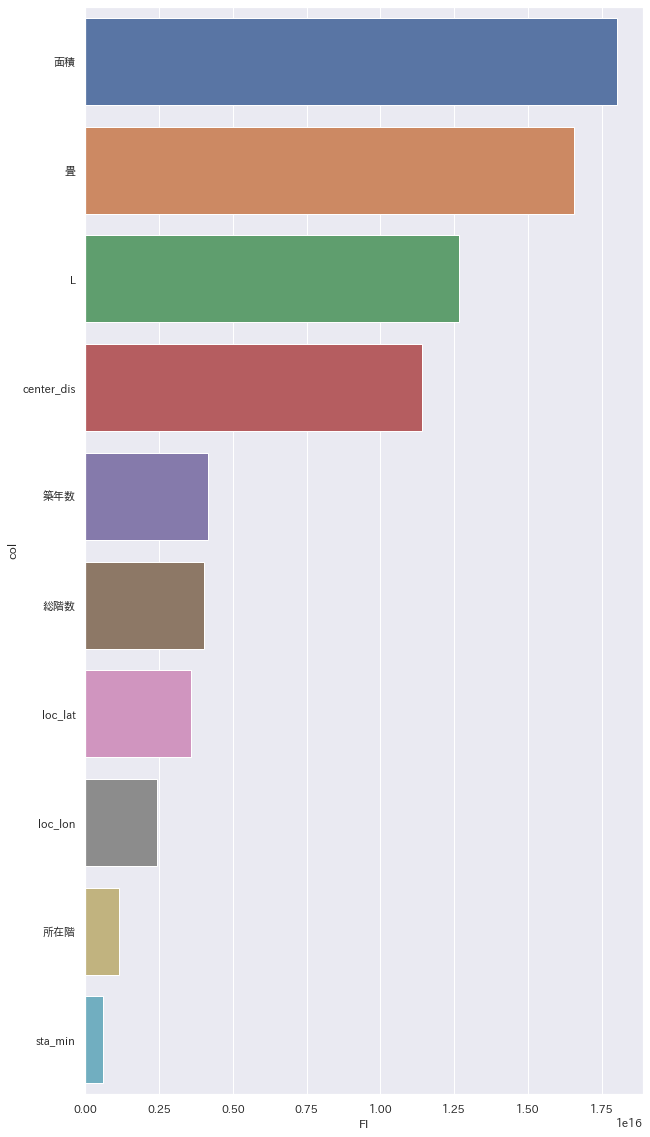

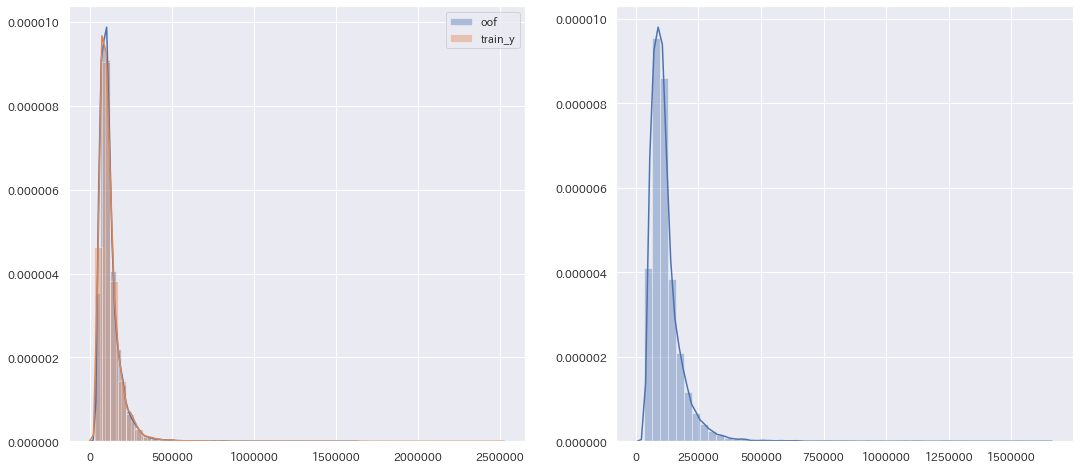

In [13]:
LGBM = RegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
lgboof, lgbpreds, lgbFIs = LGBM.fit()

RMSE :  17504.55752862452
R^2 :  0.9386733169634756


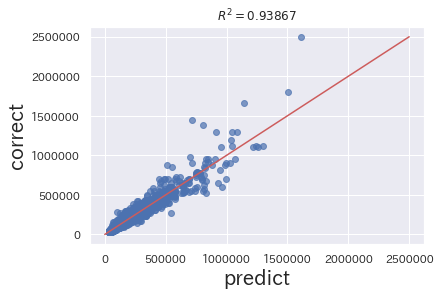

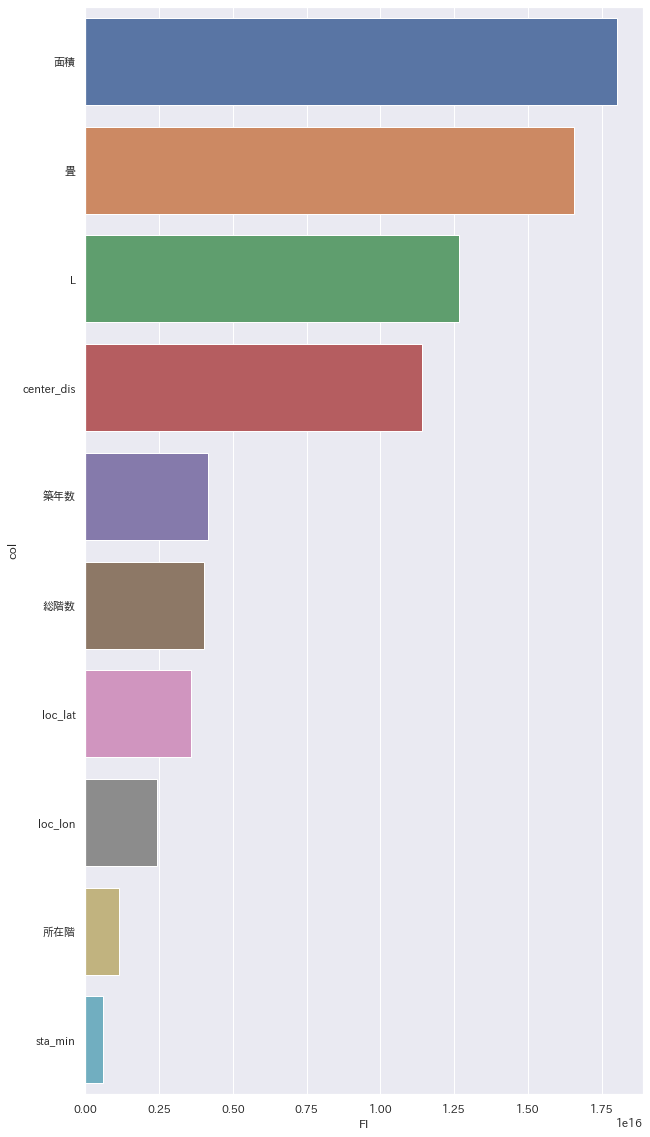

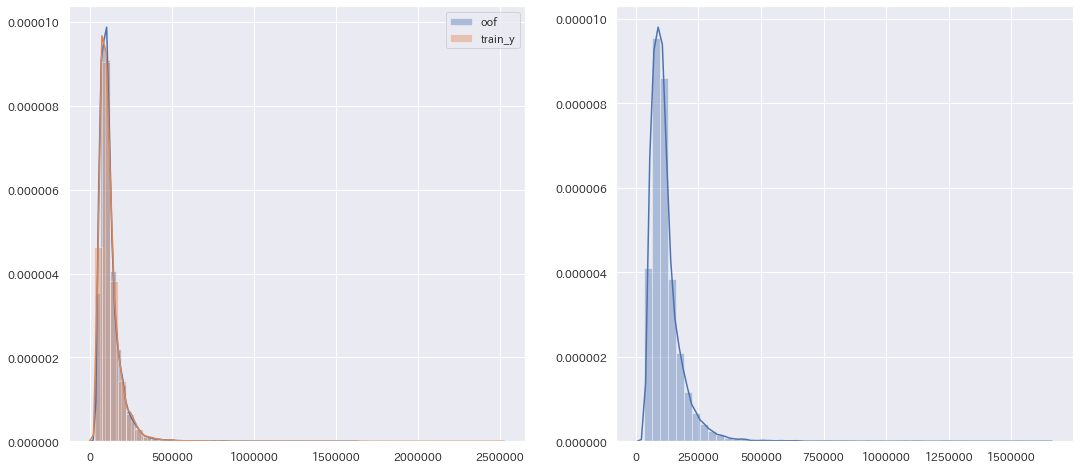

In [18]:
LGBM.plot_scatter_oofvspred()
LGBM.plot_FI(50)
LGBM.plot_pred_dist()

In [ ]:
save_data(lgboof, lgbpreds,rmse=LGBM.rmse(),name='lgb',save_dir='./stacking')

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0521721	valid_1's l1: 0.063625
[10000]	training's l1: 0.0419517	valid_1's l1: 0.060166
[15000]	training's l1: 0.0355161	valid_1's l1: 0.0582915
[20000]	training's l1: 0.0306169	valid_1's l1: 0.0568864
Early stopping, best iteration is:
[24595]	training's l1: 0.0271742	valid_1's l1: 0.0560497
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0523012	valid_1's l1: 0.0625343
[10000]	training's l1: 0.0421665	valid_1's l1: 0.0591443
[15000]	training's l1: 0.0356901	valid_1's l1: 0.0574239
Early stopping, best iteration is:
[19493]	training's l1: 0.0312764	valid_1's l1: 0.0563838
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.0518109	valid_1's l1: 0.0648776
[10000]	training's l1: 0.0418534	valid_1's l1: 0.0609929
[15000]	training's l1: 0.0353693	valid_1's l1: 0.0589889
Early st

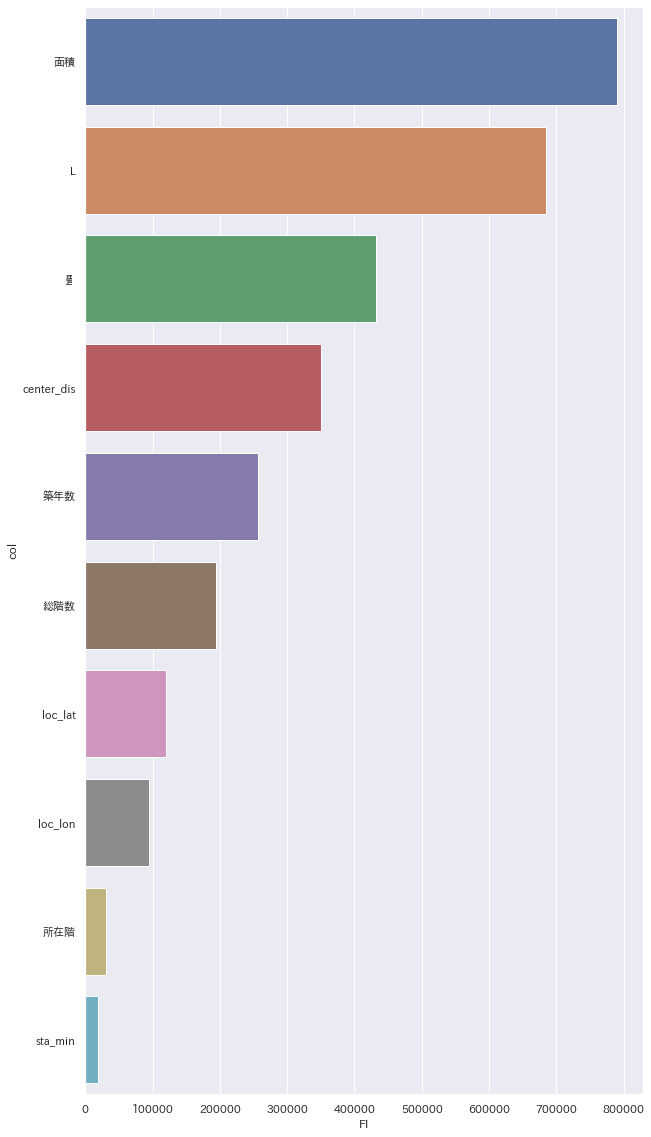

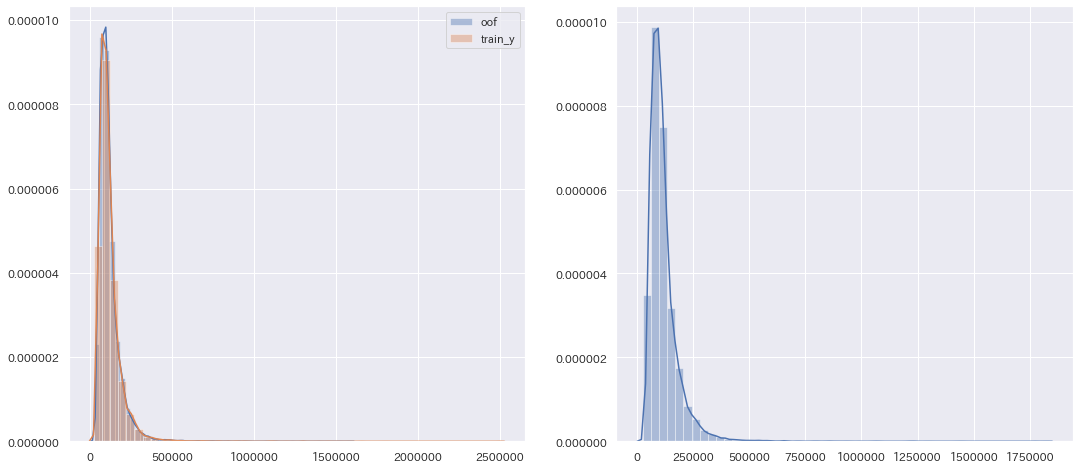

In [19]:
LogLGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
LogLGBM.plot_FI(50)
LogLGBM.plot_pred_dist()

In [20]:
save_data(log_lgboof, log_lgbpreds,rmse=LogLGBM.rmse(),name='Loglgb',save_dir='./stacking')

,id,target
0,31471,134160.108716
1,31472,119093.010802
2,31473,78015.902106
3,31474,60504.385679
4,31475,98158.311944


,id,target
0,1,82964.129277
1,2,65501.763516
2,3,108027.819779
3,4,162900.400545
4,5,61640.283276


In [20]:
xgb_params = {
        'eta':0.05,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'num_boost_round':15000,
        'early_stopping_rounds':100,
        'verbose':500
    }

xgb_log_params=xgb_params.copy()
xgb_log_params['metric']='mae'

In [21]:
xgb_params

{'eta': 0.05,
 'objective': 'reg:linear',
 'eval_metric': 'rmse',
 'num_boost_round': 15000,
 'early_stopping_rounds': 100,
 'verbose': 500}

In [22]:
LogXGB = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=xgb_log_params,
                           sk_model=None, n_splits=10, clf_type='xgb')
log_xgboof, log_xgbpreds, log_xgbFIs = LogXGB.fit()

Training on fold 1
[22:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.5194	eval-rmse:10.5107
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[5000]	train-rmse:0.02859	eval-rmse:0.080985
Stopping. Best iteration:
[6973]	train-rmse:0.021155	eval-rmse:0.080342

Training on fold 2
[22:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.5198	eval-rmse:10.5079
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[999]	train-rmse:0.065306	eval-rmse:0.089081
Training on fold 3
[22:31:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.5182	eval-rm

RMSE :  17696.11383597911
R^2 :  0.9344493151871405


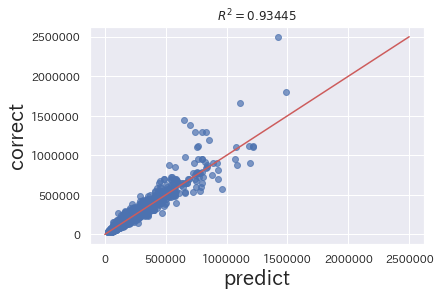

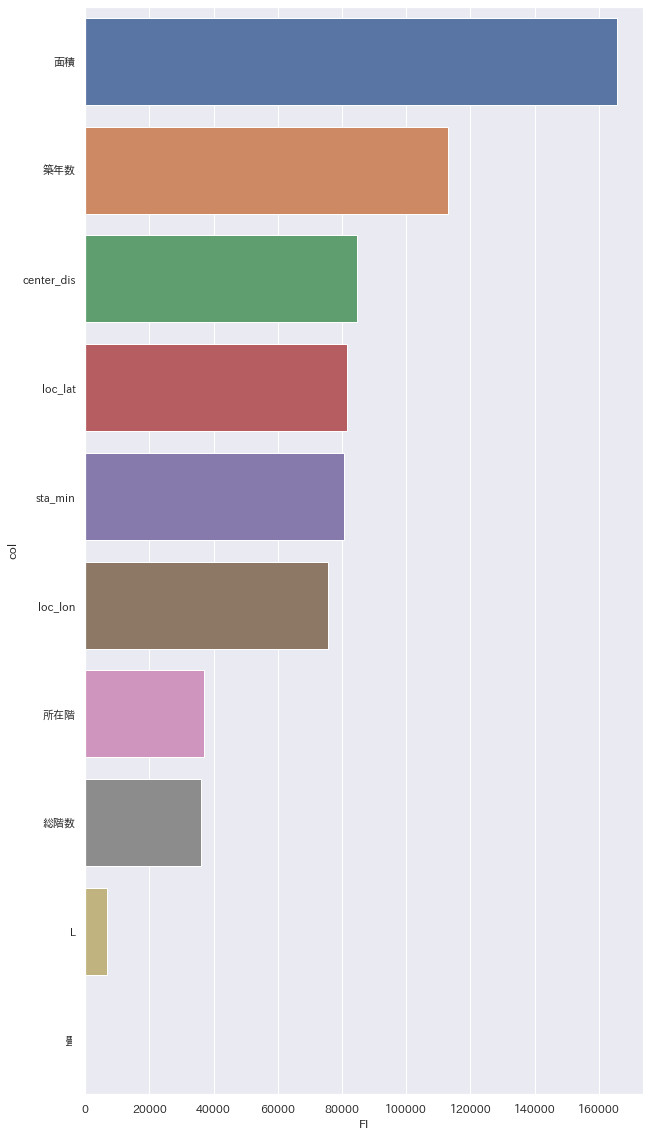

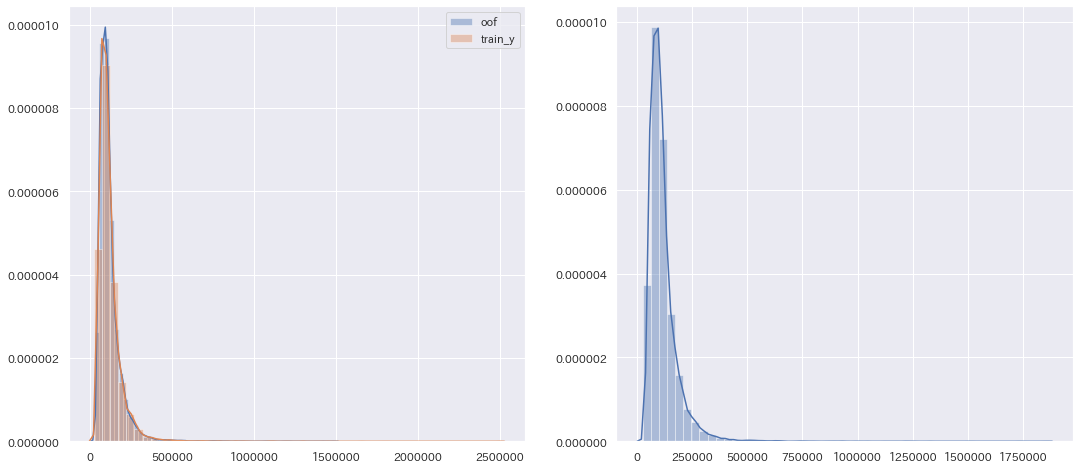

In [23]:
LogXGB.plot_scatter_oofvspred()
LogXGB.plot_FI(50)
LogXGB.plot_pred_dist()

In [24]:
save_data(log_xgboof, log_xgbpreds,rmse=LogXGB.rmse(),name='eta_005_log_xgb',save_dir='./stacking')

,id,target
0,31471,140605.053711
1,31472,116245.692383
2,31473,77708.587891
3,31474,61835.410645
4,31475,106120.092773


,id,target
0,1,85962.257812
1,2,71483.343750
2,3,105969.718750
3,4,162932.078125
4,5,64446.394531


In [25]:
XGB = RegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=xgb_params,
                           sk_model=None, n_splits=10, clf_type='xgb')
xgboof, xgbpreds, xgbFIs = XGB.fit()

Training on fold 1
[22:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:132773	eval-rmse:131190
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
Stopping. Best iteration:
[3044]	train-rmse:4467.72	eval-rmse:16121

Training on fold 2
[22:32:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:132808	eval-rmse:131055
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[842]	train-rmse:8083.98	eval-rmse:18740.4

Training on fold 3
[22:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:132625	eval-rmse:132687
Multiple eval metri

In [27]:
save_data(xgboof, xgbpreds,rmse=XGB.rmse(),name='eta_005_xgb',save_dir='./stacking')

,id,target
0,31471,136642.345703
1,31472,115601.769531
2,31473,81871.924805
3,31474,62487.687500
4,31475,111476.317383


,id,target
0,1,85593.796875
1,2,73046.101562
2,3,106381.617188
3,4,169439.015625
4,5,67661.500000


In [28]:
cat_params = {
    # 損失関数に RMSE を使う
    'loss_function': 'MAE',
    'num_boost_round': 25000,
    'early_stopping_rounds': 100,
    'verbose': 500
}

Training on fold 1
0:	learn: 11.2162152	test: 11.2076391	best: 11.2076391 (0)	total: 109ms	remaining: 45m 17s
500:	learn: 0.0767095	test: 0.0773898	best: 0.0773898 (500)	total: 4.64s	remaining: 3m 46s
1000:	learn: 0.0712379	test: 0.0727930	best: 0.0727930 (1000)	total: 9.27s	remaining: 3m 42s
1500:	learn: 0.0686208	test: 0.0708202	best: 0.0708202 (1500)	total: 13.9s	remaining: 3m 38s
2000:	learn: 0.0667893	test: 0.0697112	best: 0.0697112 (2000)	total: 18.7s	remaining: 3m 35s
2500:	learn: 0.0654256	test: 0.0688464	best: 0.0688464 (2500)	total: 23.4s	remaining: 3m 30s
3000:	learn: 0.0644405	test: 0.0683127	best: 0.0683127 (3000)	total: 28.2s	remaining: 3m 26s
3500:	learn: 0.0635943	test: 0.0678400	best: 0.0678400 (3500)	total: 33s	remaining: 3m 22s
4000:	learn: 0.0629871	test: 0.0675566	best: 0.0675566 (4000)	total: 37.8s	remaining: 3m 18s
4500:	learn: 0.0623503	test: 0.0672717	best: 0.0672717 (4500)	total: 42.5s	remaining: 3m 13s
5000:	learn: 0.0618098	test: 0.0670592	best: 0.0670592 (5

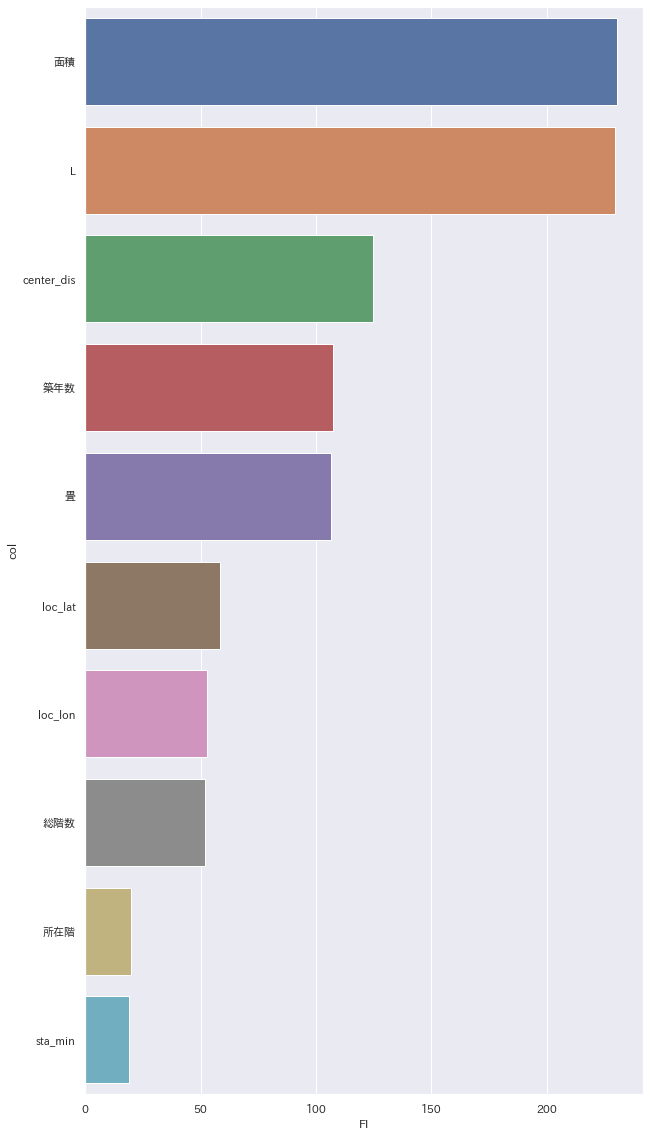

In [31]:
LogCAT = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=cat_params,
                                      sk_model=None, n_splits=10, clf_type='cat')

log_catoof, log_catpreds, log_catFIs = LogCAT.fit()
LogCAT.plot_FI(50)

In [32]:
save_data(log_catoof, log_catpreds,rmse=LogCAT.rmse(),name='Logcat',save_dir='./stacking')

,id,target
0,31471,136542.521316
1,31472,117967.514628
2,31473,79422.754459
3,31474,62483.630713
4,31475,120953.041520


,id,target
0,1,82149.753892
1,2,72533.894692
2,3,104438.748702
3,4,163493.604576
4,5,67755.371466


In [ ]:
train=pd.read_csv('./input/prep_train1030.csv')
test=pd.read_csv('./input/prep_train1030.csv')
y_train = train['賃料']